In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import datetime

In [3]:
df_price = pd.read_csv(os.path.join('005930.KS.csv'), encoding='utf8')
df_price.describe()
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-03,25900.0,25940.0,25720.0,25800.0,260.387482,8334750.0
1,2015-12-04,25500.0,25600.0,25340.0,25380.0,256.148621,9635550.0
2,2015-12-07,25380.0,25500.0,25240.0,25240.0,254.735657,9805350.0
3,2015-12-08,25240.0,25440.0,25240.0,25240.0,254.735657,6916100.0
4,2015-12-09,25240.0,25500.0,25240.0,25260.0,254.937500,9090600.0


In [4]:
df_price = df_price.dropna() #결측치제거

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.088765  0.069433  0.085088  0.069817  0.128859
1     0.080189  0.062235  0.076923  0.060877  0.148970
2     0.077616  0.060119  0.074774  0.057897  0.151595
3     0.074614  0.058848  0.074774  0.057897  0.106926
4     0.074614  0.060119  0.074774  0.058323  0.140544
...        ...       ...       ...       ...       ...
1215  0.950686  0.959780  0.950580  0.968072  0.294109
1216  0.991424  0.968247  0.984959  0.972329  0.217427
1217  1.000000  0.972481  0.965621  0.940400  0.677337
1218  0.972127  0.966130  0.974216  0.963814  0.345187
1219  1.000000  1.000000  1.000000  1.000000  0.429767

[1220 rows x 5 columns]


In [7]:
train = df_scaled[:-300]
test = df_scaled[-300:]

In [8]:
def make_dataset(data, label, window_size=50):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((280, 20, 4), (280, 1))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(16, input_shape=(20,4), activation='relu', return_sequences=False))
model.add(Dense(1))

In [12]:
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5) #overfitting 방지
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
44/45 [============================>.] - ETA: 0s - loss: 0.0736
Epoch 00001: val_loss improved from inf to 0.00986, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 10ms/step - loss: 0.0722 - val_loss: 0.0099
Epoch 2/20
37/45 [=======================>......] - ETA: 0s - loss: 0.0064
Epoch 00002: val_loss improved from 0.00986 to 0.00253, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 3/20
40/45 [=========================>....] - ETA: 0s - loss: 0.0017
Epoch 00003: val_loss improved from 0.00253 to 0.00071, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 7.0890e-04
Epoch 4/20
44/45 [============================>.] - ETA: 0s - loss: 7.4670e-04
Epoch 00004: val_loss improved from 0.00071 to 0.00064, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 6ms/step - loss: 7.4384e-04 - 

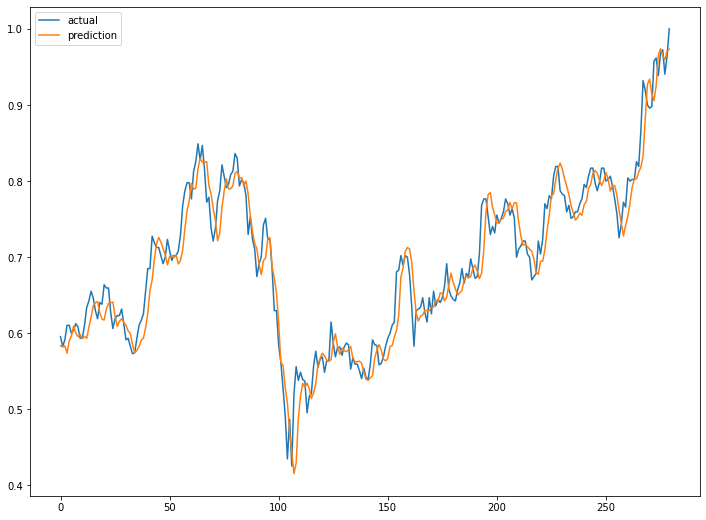

In [13]:
model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()